In [27]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [28]:
from lmfit import Parameters
from mlsaft.extras.utils.plotting import plot_pressure_density_phase_diagram, get_functional_group_counts, parity_plot_grid
from mlsaft.extras.utils.pcsaft import create_parameters,predict_phase_diagram, J_BIGGS_JOBACK_SMARTS
from mlsaft.extras.utils.molecular_fingerprints import _canonicalize_smiles
import plotly.express as px
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Descriptors import ExactMolWt
from scipy.interpolate import griddata
import numpy as np
import pandas as pd
import seaborn as sns
from typing import Optional
from pathlib import Path

In [29]:
%load_ext kedro.extras.extensions.ipython
%reload_kedro

The kedro.extras.extensions.ipython extension is already loaded. To reload it, use:
  %reload_ext kedro.extras.extensions.ipython


In [30]:
experimental_data = catalog.load("dortmund_base_pure_component_filtered")
dipole_data = catalog.load("dortmund_dipole_moment_predictions")
regressed_data = catalog.load("pcp_saft_regressed_pure_parameters")
removed_data = catalog.load("pcp_saft_regressed_pure_parameters_removed")
lin_parameters = catalog.load("loetgering_lin_parameters")

2024-02-06 06:41:50,603 - kedro.io.data_catalog - INFO - Loading data from 'dortmund_base_pure_component_filtered' (ParquetDataSet)...
2024-02-06 06:41:50,813 - kedro.io.data_catalog - INFO - Loading data from 'dortmund_dipole_moment_predictions' (ParquetDataSet)...
2024-02-06 06:41:50,820 - kedro.io.data_catalog - INFO - Loading data from 'pcp_saft_regressed_pure_parameters' (ParquetDataSet)...
2024-02-06 06:41:50,828 - kedro.io.data_catalog - INFO - Loading data from 'pcp_saft_regressed_pure_parameters_removed' (CSVDataSet)...
2024-02-06 06:41:50,838 - kedro.io.data_catalog - INFO - Loading data from 'loetgering_lin_parameters' (CSVDataSet)...


## Comparison to existing data

In [31]:
new_smiles = [_canonicalize_smiles(smi) for smi in lin_parameters["SMILES"]]
lin_parameters["smiles_1"] = new_smiles
lin_merged = lin_parameters.merge(
    regressed_data, 
    on="smiles_1", 
    how="left",
    suffixes=["_lin", "_ours"]
).dropna()
for param in ['m', 'sigma', 'epsilon_k', 'mu', "KAB", 'epsilonAB']:
    lin_merged[f"{param}_diff"] = (lin_merged[f"{param}_lin"] - lin_merged[f"{param}_ours"]).abs() / lin_merged[f"{param}_lin"] * 100

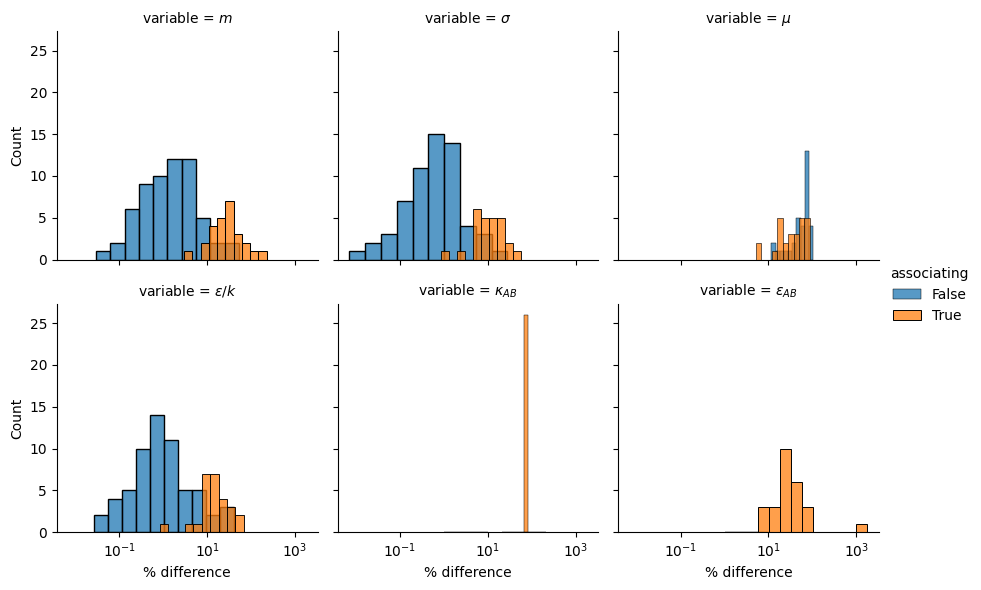

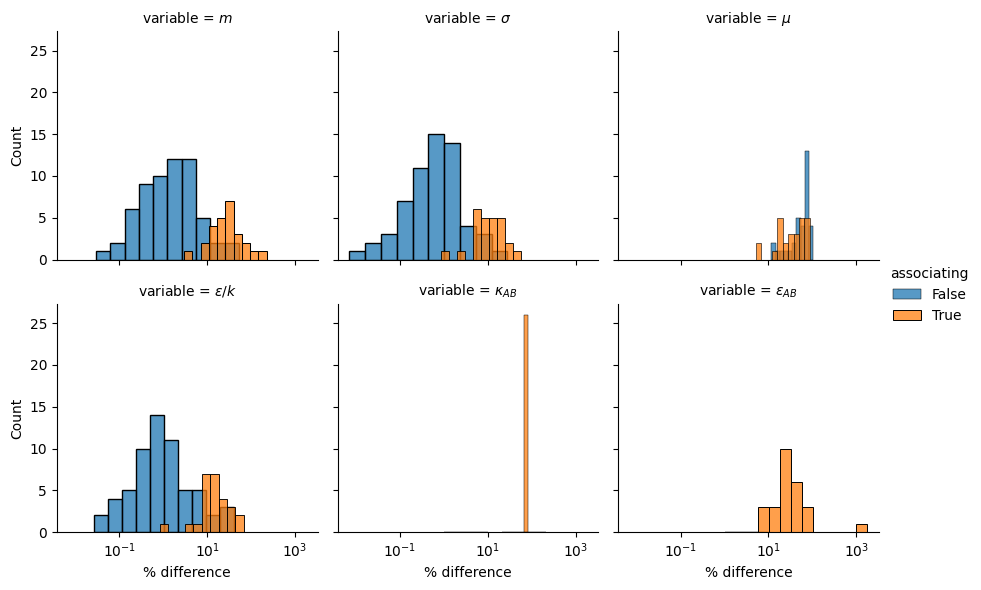

In [32]:
new_lin = pd.melt(
    lin_merged, 
    id_vars=["smiles_1", "associating"], 
    value_vars=["m_diff", "sigma_diff", "mu_diff", "epsilon_k_diff","KAB_diff", "epsilonAB_diff"],
).replace({
    "m_diff": "$m$",
    "sigma_diff": "$\sigma$",
    "mu_diff": "$\mu$",
    "epsilon_k_diff": "$\epsilon/k$", 
    "KAB_diff": "$\kappa_{AB}$",
    "epsilonAB_diff": "$\epsilon_{AB}$"
}).rename(columns={"value": "% difference"})
g = sns.FacetGrid(
    new_lin,
    col="variable", 
    col_wrap=3, 
    sharex=True,
    hue="associating",
    margin_titles=True,
    legend_out=True
)
g.map(sns.histplot, "% difference", bins=10, log_scale=True)
g.add_legend()
g.figure.savefig("../data/08_reporting/lin_differences.png", dpi=300)
g.figure

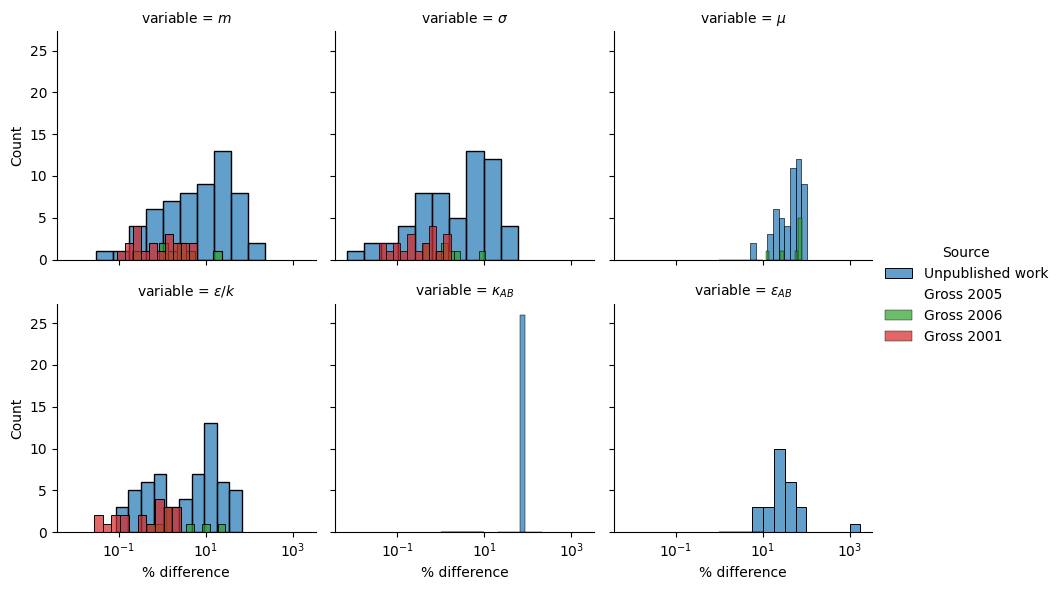

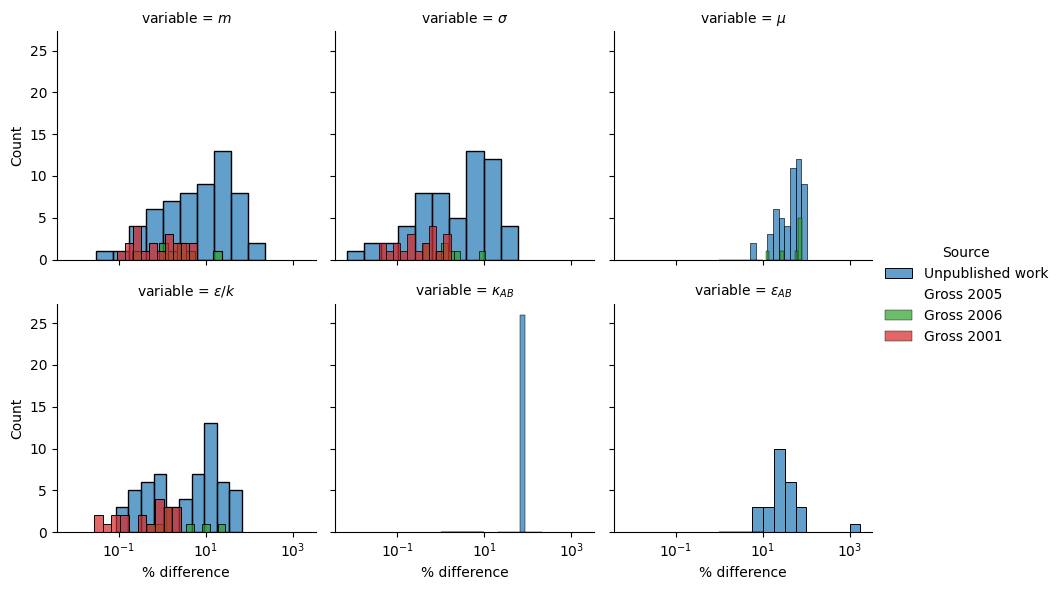

In [33]:
new_lin = pd.melt(
    lin_merged, 
    id_vars=["smiles_1", "Source"], 
    value_vars=["m_diff", "sigma_diff", "mu_diff", "epsilon_k_diff","KAB_diff", "epsilonAB_diff"],
).replace({
    "m_diff": "$m$",
    "sigma_diff": "$\sigma$",
    "mu_diff": "$\mu$",
    "epsilon_k_diff": "$\epsilon/k$", 
    "KAB_diff": "$\kappa_{AB}$",
    "epsilonAB_diff": "$\epsilon_{AB}$"
}).rename(columns={"value": "% difference"}).replace({
    235: "Unpublished work",
    111: "Gross 2005",
    110: "Gross 2006",
    105: "Gross 2001"
})
g = sns.FacetGrid(
    new_lin,
    col="variable", 
    col_wrap=3, 
    sharex=True,
    hue="Source",
    hue_order=["Unpublished work", "Gross 2005", "Gross 2006", "Gross 2001"],
    margin_titles=True,
    legend_out=True
)
g.map(sns.histplot, "% difference", bins=10, log_scale=True, alpha=0.7)
g.add_legend()
g.figure.savefig("../data/08_reporting/lin_differences_publication.png", dpi=300)
g.figure

In [34]:
experimental_data[experimental_data["#DDB"]==84]

,Component,#DDB,T,P,Type,DEN,cas_number_1,name_1,alternative_name_1,smiles_1,status_1
7687,Acetic acid,84,391.25,101.325,Experimental Data,NaN,64-19-7,Acetic acid,Ethanoic acid,CC(=O)O,Include
10941,Acetic acid,84,338.45,15.705,Experimental Data,NaN,64-19-7,Acetic acid,Ethanoic acid,CC(=O)O,Include
10942,Acetic acid,84,347.55,22.958,Experimental Data,NaN,64-19-7,Acetic acid,Ethanoic acid,CC(=O)O,Include
10943,Acetic acid,84,360.05,36.384,Experimental Data,NaN,64-19-7,Acetic acid,Ethanoic acid,CC(=O)O,Include
13068,Acetic acid,84,352.39,26.664,Experimental Data,NaN,64-19-7,Acetic acid,Ethanoic acid,CC(=O)O,Include
...,...,...,...,...,...,...,...,...,...,...,...
359082,Acetic acid,84,298.15,101.300,Experimental Data,1043.93,64-19-7,Acetic acid,Ethanoic acid,CC(=O)O,Include
359083,Acetic acid,84,303.15,101.300,Experimental Data,1038.26,64-19-7,Acetic acid,Ethanoic acid,CC(=O)O,Include
359084,Acetic acid,84,308.15,101.300,Experimental Data,1032.62,64-19-7,Acetic acid,Ethanoic acid,CC(=O)O,Include
359085,Acetic acid,84,313.15,101.300,Experimental Data,1026.98,64-19-7,Acetic acid,Ethanoic acid,CC(=O)O,Include


## Functional group analysis

In [35]:
thermo_scores = catalog.load("thermo_scores")["RF"]()
thermo_scores["rho_mape_100"] = thermo_scores["rho_mape"]*100
thermo_scores["pvap_mape_100"] = thermo_scores["pvap_mape"]*100

2024-02-06 06:41:55,036 - kedro.io.data_catalog - INFO - Loading data from 'thermo_scores' (PartitionedDataset)...


What I neeed to do:

- [x] Create a dictionary with keys as functional group and values as a list of corresponding SMILES
- [x] Use that dictionary to create a dataframe with functional group and average error in each functional group
- [x] Create a box and whiskers plot
- [x] Group functional groups into classes

In [36]:
classes = {
    'Methyl': 'Alkanes',
    'Secondary acyclic': 'Alkanes',
    'Tertiary acyclic': 'Alkanes',
    'Quaternary acyclic': 'Alkanes',
    'Primary alkene': 'Alkenes',
    'Secondary alkene acyclic': 'Alkenes',
    'Tertiary alkene acyclic': 'Alkenes',
    'Alkyne': 'Alkynes',
    'Aliphatic cyclohexane CH2': 'Cyclic compounds',
    'Aliphatic cyclohexane': 'Cyclic compounds',
    'Aliphatic cyclopentane CH2': 'Cyclic compounds',
    'Aliphatic cyclopentane CH': 'Cyclic compounds',
    'Alcohol': 'Alcohols',
    'Aromatic carbon': 'Aromatics',
    'Aromatic carbon-hydrogen': 'Aromatics',
    'Carbonyl acyclic': 'Carbonyl acyclic',
    'Aliphatic Ether': 'Ethers',
    'Aldehyde': 'Aldehydes',
    'Ester': 'Esters',
    'Terminal Ester': 'Esters',
    'Primary amino': 'Amines'
}

In [37]:
# Add classes
NEW_J_BIGGS_JOBACK_SMARTS = []
for i, el in enumerate(J_BIGGS_JOBACK_SMARTS):
    NEW_J_BIGGS_JOBACK_SMARTS.append([el[0], classes[el[0]], el[2]])
    
# Add some classes
NEW_J_BIGGS_JOBACK_SMARTS.append(
    ["Halogens", "Halogens", r"*-[#9,#17,#35,#53]"]
)
    
joback_fragments = pd.DataFrame(
    NEW_J_BIGGS_JOBACK_SMARTS, 
    columns=["name", "class", "smarts"]
)

2024-02-06 06:41:55,192 - kedro.io.data_catalog - INFO - Loading data from 'fragments' (CSVDataSet)...


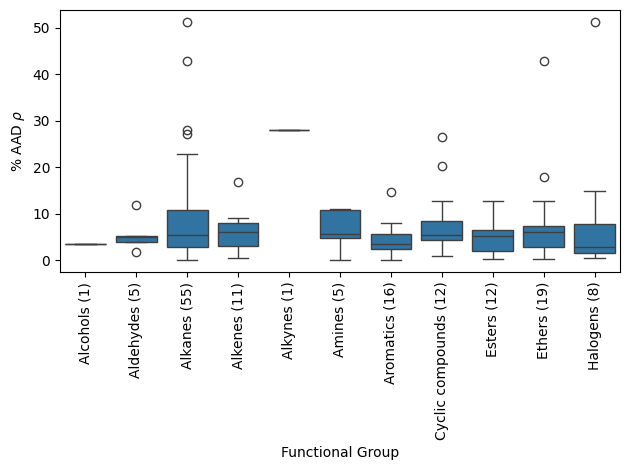

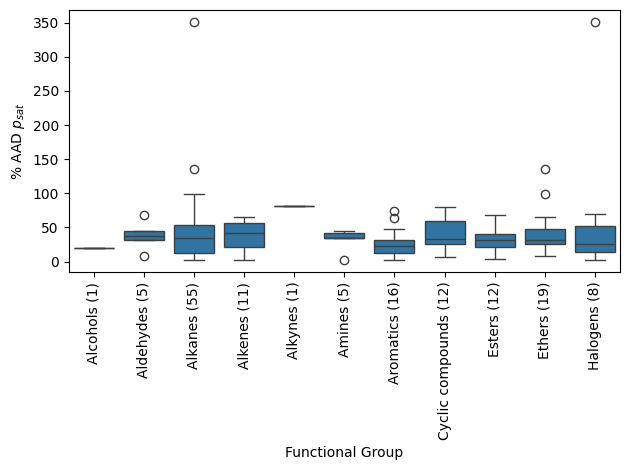

In [38]:
def make_functional_group_boxplot(
    data: pd.DataFrame,
    fragments_data: pd.DataFrame,
    error_column: str,
    smiles_column: str = "smiles",
    plot_top_k: int = 10,
    y_label: str = "Error",
    log_scale: bool = False,
):
    # Create mols and get functional groups
    all_smiles = data[smiles_column].astype(str).tolist()
    mols = [Chem.MolFromSmiles(smi) for smi in all_smiles]  # type: ignore
    fragments = {}
    for _, row in fragments_data.iterrows():
        clss = row["class"]
        smarts = Chem.MolFromSmarts(row["smarts"])
        if clss in fragments:
            fragments[clss].append(smarts)  # type: ignore
        else:
            fragments[clss] = [smarts]

    # Find molecule
    functional_groups = {label: [] for label in fragments}
    for mol in mols:
        for label, fragments_list in fragments.items():
            for fragment in fragments_list:
                n_matches = len(mol.GetSubstructMatches(fragment))
                smi = Chem.MolToSmiles(mol)
                if n_matches > 0 and smi not in functional_groups[label]:
                    functional_groups[label].append(smi)

    # Create dataframe with errors
    functional_group_errors = []
    for label, smiles_list in functional_groups.items():
        for smiles in smiles_list:
            row = data[data[smiles_column] == smiles]
            if not row.empty:
                functional_group_errors.append({
                    "FG": label,
                    y_label: float(row[error_column])
                })
    functional_group_errors_df = pd.DataFrame(functional_group_errors)
    
    # Counts
    groups = functional_group_errors_df.groupby("FG").count()
    functional_group_errors_df["counts"] = 0
    for i, row in functional_group_errors_df.iterrows():
        fg = row["FG"]
        functional_group_errors_df.at[i, "counts"] = groups.loc[fg].iloc[0]
    functional_group_errors_df["Functional Group"] = (
        functional_group_errors_df["FG"] + 
        " (" + 
        functional_group_errors_df["counts"].astype(str)
        + ")"
    )


    # Filter to top k
    if plot_top_k:
        top_groups = (
            groups.sort_values(by=y_label, ascending=False)
            .iloc[:plot_top_k]
            .index.tolist()
        )
        functional_group_errors_df = functional_group_errors_df[
            functional_group_errors_df["FG"].isin(top_groups)
        ]
        
    # Sort
    functional_group_errors_df = functional_group_errors_df.sort_values("FG")

    # Create boxplot
    fig, ax = plt.subplots(1)
    g = sns.boxplot(
        data=functional_group_errors_df, 
        x="Functional Group", 
        log_scale=log_scale, 
        y=y_label,
        ax=ax
    )
    _ = g.set_xticklabels(g.get_xticklabels(), rotation=90)
    
    return g


fragments_data = catalog.load("fragments")
# Density
g = make_functional_group_boxplot(
    data = thermo_scores,
    smiles_column = "smiles",
    error_column = "rho_mape_100",
    plot_top_k = 20,
    y_label = r"% AAD $\rho$",
    log_scale = False,
    fragments_data = joback_fragments
)
fig = g.figure
g.figure.get_axes()
fig.tight_layout()
fig.savefig("../data/08_reporting/functional_group_analysis_rf_rho.png", dpi=300)


# Density
g = make_functional_group_boxplot(
    data = thermo_scores,
    smiles_column = "smiles",
    error_column = "pvap_mape_100",
    plot_top_k = 20,
    y_label = r"% AAD $p_{sat}$",
    log_scale = False,
    fragments_data = joback_fragments,
)
fig = g.figure
fig.tight_layout()
fig.savefig("../data/08_reporting/functional_group_analysis_rf_pvap.png", dpi=300)

## Temperature dependence of error

In [39]:
p = Path("../data/08_reporting/feos_predictions/data")
arrs = []
pvap_arrs = pd.concat([pd.read_csv(f)for f in p.glob("*_pvap.csv")])
rho_arrs = pd.concat([pd.read_csv(f)for f in p.glob("*_rho.csv")])

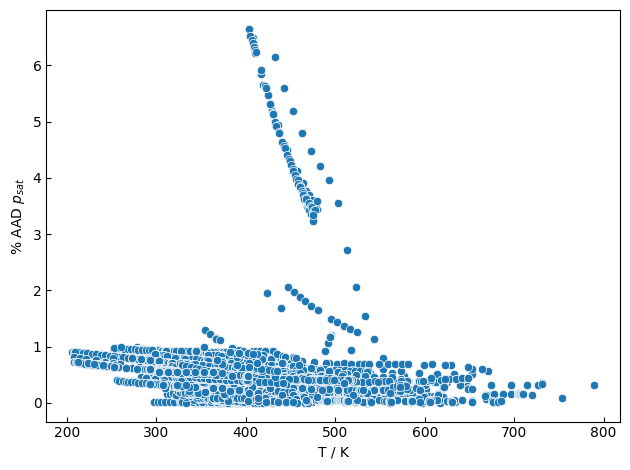

In [40]:
fig, ax = plt.subplots(1)
g = sns.scatterplot(data=pvap_arrs.abs(), x="T", y="residual", ax=ax)
ax.set_xlabel("T / K")
ax.set_ylabel("% AAD $p_{sat}$")
ax.tick_params(direction="in")
fig.tight_layout()
fig.savefig("../data/08_reporting/temperature_analysis_rf_pvap.png", dpi=300)

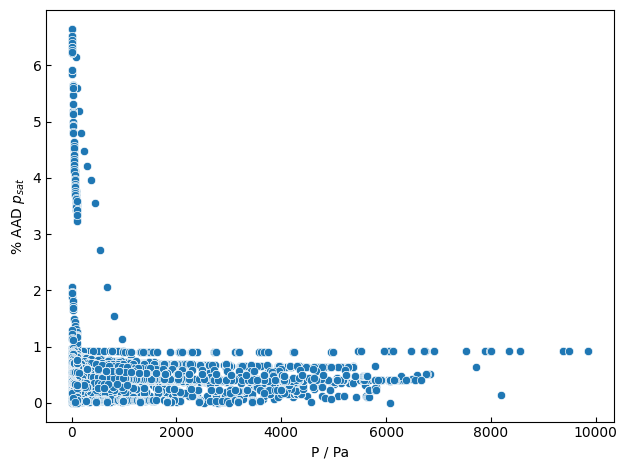

In [41]:
fig, ax = plt.subplots(1)
g = sns.scatterplot(data=pvap_arrs.abs(), x="P", y="residual", ax=ax)
ax.set_xlabel("P / Pa")
ax.set_ylabel("% AAD $p_{sat}$")
ax.tick_params(direction="in")
fig.tight_layout()
fig.savefig("../data/08_reporting/pressure_analysis_rf_pvap.png", dpi=300)

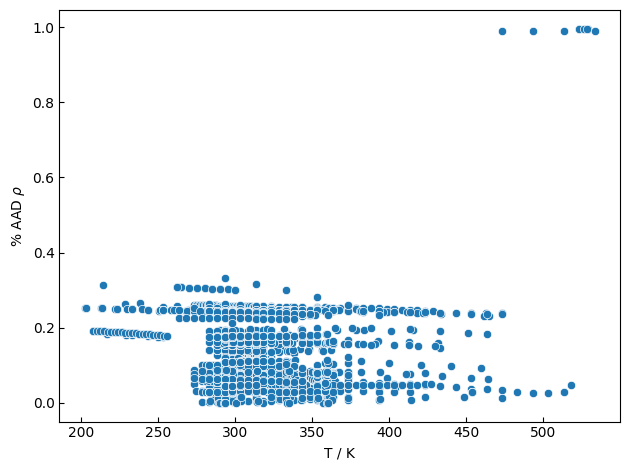

In [42]:
fig, ax = plt.subplots(1)
g = sns.scatterplot(data=rho_arrs.abs(), x="T", y="residual", ax=ax)
ax.set_xlabel("T / K")
ax.set_ylabel(r"% AAD $\rho$")
ax.tick_params(direction="in")
fig.tight_layout()
fig.savefig("../data/08_reporting/temperature_analysis_rf_rho.png", dpi=300)

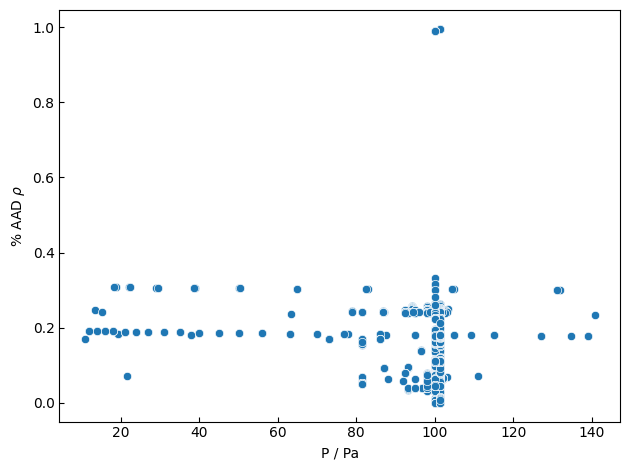

In [43]:
fig, ax = plt.subplots(1)
g = sns.scatterplot(data=rho_arrs.abs(), x="P", y="residual", ax=ax)
ax.set_xlabel("P / Pa")
ax.set_ylabel(r"% AAD $\rho$")
ax.tick_params(direction="in")
fig.tight_layout()
fig.savefig("../data/08_reporting/pressure_analysis_rf_rho.png", dpi=300)

## Model Prediction vs Regression 

In [44]:
predicted_dfs = catalog.load("all_data")
predicted_dfs = {name: df_func() for name, df_func in predicted_dfs.items()}

2024-02-06 06:41:57,805 - kedro.io.data_catalog - INFO - Loading data from 'all_data' (PartitionedDataset)...


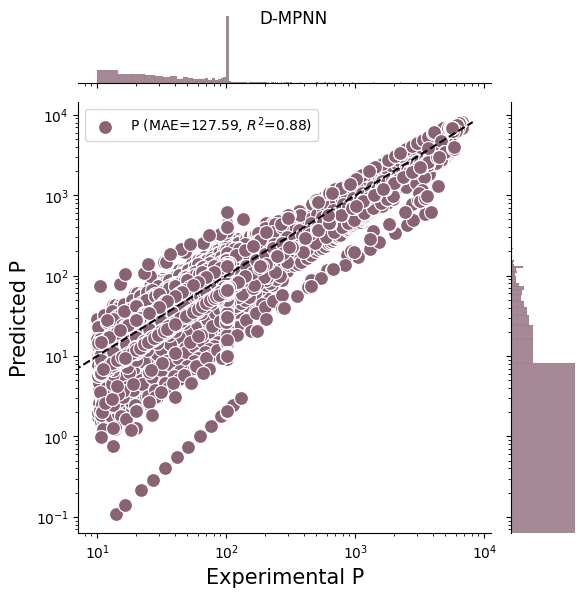

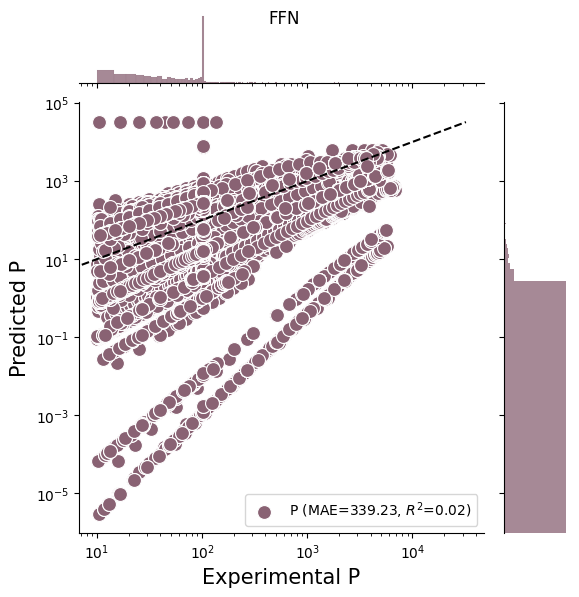

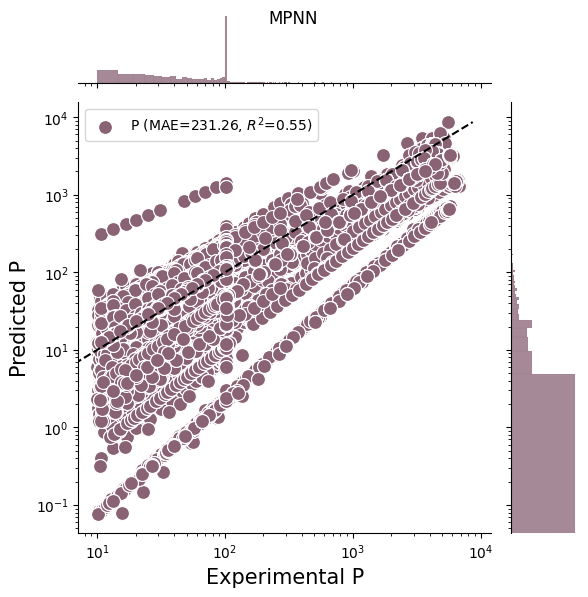

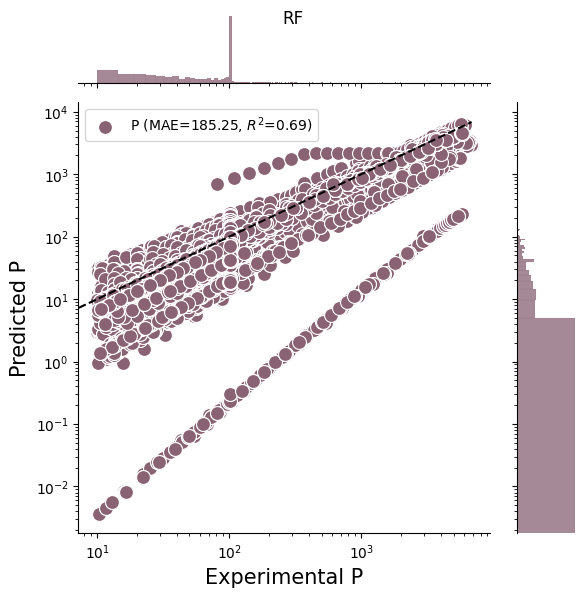

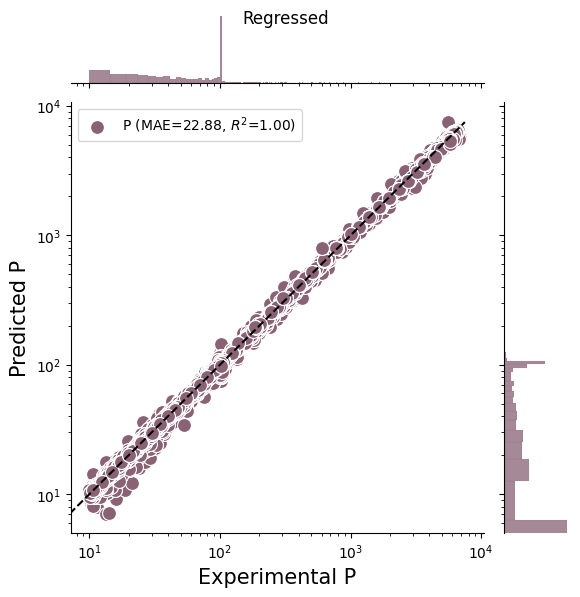

In [45]:
figs = parity_plot_grid(predicted_dfs, targets={name: ["P"] for name in predicted_dfs})
for name, g in figs.items():
    g.fig.suptitle(name.split("_")[0])
    g.ax_joint.set_xscale('log')
    g.ax_joint.set_yscale('log')
    g.figure.savefig(f"../data/08_reporting/model_thermo_predictions/parity_plot_{name}.png")

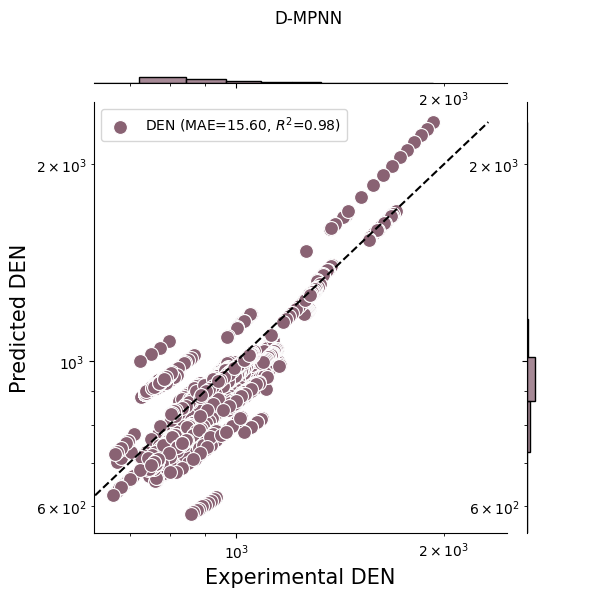

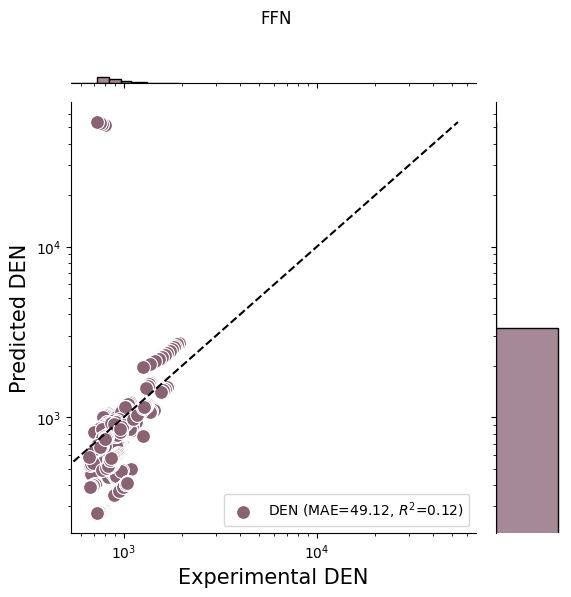

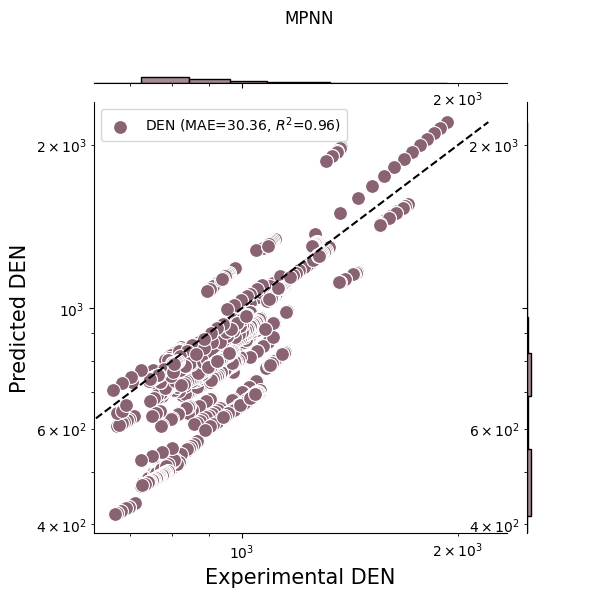

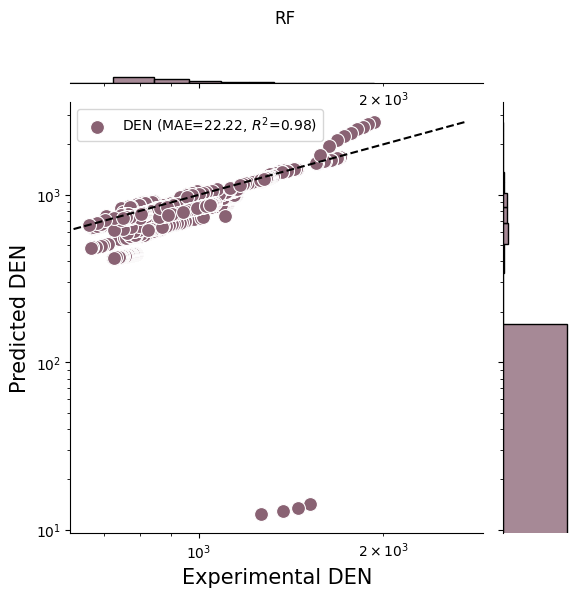

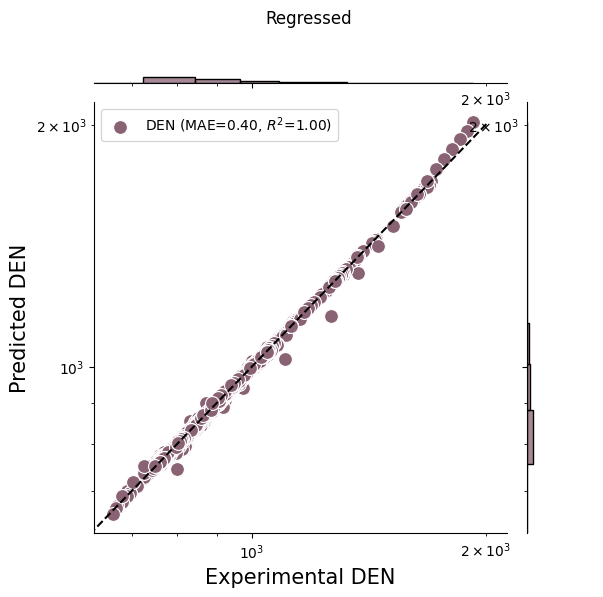

In [46]:
figs = parity_plot_grid(
    predicted_dfs, 
    targets={name: ["DEN"] for name in predicted_dfs}
)
for name, g in figs.items():
    g.fig.suptitle(name.split("_")[0])
    g.ax_joint.set_xscale('log')
    g.ax_joint.set_yscale('log')
    g.figure.savefig(f"../data/08_reporting/model_thermo_predictions/parity_plot_{name}.png")